# Project 4: Web Scraping Indeed.com & Predicting Salaries

In Project 4, we practice two major skills: collecting data via  web scraping and building a binary predictor with Logistic Regression.

We will collect salary information on data science jobs in a variety of markets. Using location, title, and job summary, we'll predict the salary of the job. For job posting sites, this is extraordinarily useful. While most listings DO NOT come with salary information (as you will see in this exercise), extrapolating expected salary can help guide negotiations.

Normally, we can use regression for this task; however, we will convert this problem into classification and use Logistic Regression.

- Q: Why would we want this to be a classification problem?
- A: While more precision may be better, there is a fair amount of natural variance in job salaries - predicting a range be may be useful.

Section one focuses on scraping Indeed.com; then we use listings with salary information to build a model and predict additional salaries.

### Scraping job listings from Indeed.com

Scrape job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries. First, look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10")

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract.

#### Setup a request (using `requests`) to the URL below. Use BeautifulSoup to parse the page and extract all results (HINT: Look for div tags with class name result)

The URL here has many query parameters

- `q` for the job search
- This is followed by "+20,000" to return results with salaries (or expected salaries >$20,000)
- `l` for a location 
- `start` for what result number to start on

Problem Statement: Enter the statement here

In [89]:
import requests
import bs4
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import patsy
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import cross_val_score
from patsy import dmatrix
from sklearn.metrics import roc_curve, auc

plt.style.use('seaborn-white')

Problem Statement: Predicting the salaries of Data scientists form different markets or locations widely depends on many factors. With available data from a job postings on indeed.com, can saries for Data scientist positions be predicted? This is important in negotiations for firms when negotiating contracts. If predictions can be made then what are the factors that contribute to higher salary in a market?

In [90]:
# #read site in soup
# url= "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=Atlanta%2C+GA&start=10&pp="
# r = requests.get(url)
# soup = BeautifulSoup(r.content, "lxml")

# #Append to the full set of results
# results = soup.find_all('div', { "class" :"result" })
# results

Let's look at one result more closely. A single `result` looks like

```
<div class=" row result" data-jk="2480d203f7e97210" data-tn-component="organicJob" id="p_2480d203f7e97210" itemscope="" itemtype="http://schema.org/JobPosting">
<h2 class="jobtitle" id="jl_2480d203f7e97210">
<a class="turnstileLink" data-tn-element="jobTitle" onmousedown="return rclk(this,jobmap[0],1);" rel="nofollow" target="_blank" title="AVP/Quantitative Analyst">AVP/Quantitative Analyst</a>
</h2>
<span class="company" itemprop="hiringOrganization" itemtype="http://schema.org/Organization">
<span itemprop="name">
<a href="/cmp/Alliancebernstein?from=SERP&amp;campaignid=serp-linkcompanyname&amp;fromjk=2480d203f7e97210&amp;jcid=b374f2a780e04789" target="_blank">
    AllianceBernstein</a></span>
</span>
<tr>
<td class="snip">
<nobr>$117,500 - $127,500 a year</nobr>
<div>
<span class="summary" itemprop="description">
C onduct quantitative and statistical research as well as portfolio management for various investment portfolios. Collaborate with Quantitative Analysts and</span>
</div>
</div>
</td>
</tr>
</table>
</div>
```

While this has some of the more verbose elements removed, we can see that there is some structure to the above:
- The salary is available in a `nobr` element inside of a `td` element with `class='snip`.
- The title of a job is in a link with class set to `jobtitle` and a `data-tn-element="jobTitle`.  
- The location is set in a `span` with `class='location'`. 
- The company is set in a `span` with `class='company'`. 

In [91]:
# results = soup.find_all('div', { "class" : "result" })
# df = pd.DataFrame()
# for element in range(len(results)):
#     title=results[element].find("a",{'data-tn-element' : 'jobTitle'}).get_text().strip()
#     company=results[element].find("span",{"class":"company"}).get_text().strip()
#     location=results[element].find("span",{"class":"location"}).get_text().strip()
#     salary=results[element].find("td",{"class":"snip"}).get_text().strip()
#     df=df.append({"Title":title, "Company":company, "Location": location,"Salary": salary},ignore_index=True)
    
# df

### Write 4 functions to extract each item: location, company, job, and salary.

example: 
```python
def extract_location_from_result(result):
    return result.find ...
```

- Make sure these functions are robust and can handle cases where the data/field may not be available
- Test the functions on the results above

In [92]:
# get text
# def extract_text(el):
#     if el:
#         return el.text.strip()
#     else:
#         return ''
        
# # company
# def get_company_from_result(result):
#     return extract_text(result.find('span', {'class' : 'company'}))

# # location
# def get_location_from_result(result):
#     return extract_text(result.find('span', {'class' : 'location'}))
# # summary
# def get_summary_from_result(result):
#     return extract_text(result.find('span', {'class' : 'sumamry'}))
# # title
# def get_title_from_result(result):
#     return extract_text(result.find('a', {'data-tn-element' : 'jobTitle'}))
# # get salary if exists
# def get_salary_from_result(result):
#     salary_table = result.find('td', {'class' : 'snip'})
#     if salary_table:
#         snip = salary_table.find('nobr')
#         if snip:
#             return snip.text.strip()   
#     return None

Now, to scale up our scraping, we need to accumulate more results. We can do this by examining the URL above.

- "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

There are two query parameters here we can alter to collect more results: the `l=New+York` and the `start=10`. The first controls the location of the results (so we can try different city). The second controls where in the results to start and gives 10 results (so we can keep incrementing this by 10 to move further within the list).

#### Complete the following code to collect results from multiple cities and start points. 
- Enter your city below to add it to the search
- Remember to convert your salary to U.S. Dollars to match the other cities if the currency is different

#### Use the functions you wrote above to parse out the 4 fields - location, title, company and salary. Create a dataframe from the results with those 4 columns.

In [93]:
# # create template URL and max number of results (pages) to pull
# url_template = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l={}&start={}&pp="

# cities=['atlanta','charlotte','newark','chicago','los+angeles','seattle',
#         'richmond','raleigh','miami','new+york','detroit','san+francisco','boston',
#         'dallas','houston','']

# df=pd.DataFrame()
# # for loop to pull data with bs4
# for city in cities: 
#     for i in range (0,500,10):
#         link=url_template.format(city,i)
#         r=requests.get(link)
#         soup=BeautifulSoup(r.content,'lxml')
#         results = soup.find_all('div', { "class" : "result" })
        
#         for result in results:
#             if result:
#                 company = get_company_from_result(result)
#                 title = get_title_from_result(result)
#                 location = get_location_from_result(result)
#                 salary = get_salary_from_result(result)
#                 df=df.append({"Company Name": company, "Job Title": title, "Location": location,
#                              "Salary": salary}, ignore_index=True)
            
# df

In [94]:
# df.to_csv("indeed_file.csv",encoding='utf-8')

In [95]:
df=pd.read_csv("indeed_file.csv")
df.head()

,Unnamed: 0,Company Name,Job Title,Location,Salary
0,0,Predictive Science,Data Scientist,United States,NaN
1,1,MobileDev Power,Data Scientist With Predictive Modeling,"Atlanta, GA 30305",NaN
2,2,Home Depot,DATA SCIENTIST,"Atlanta, GA 30354",NaN
3,3,"Vision3 Solutions, Inc",Data Scientist- Big Data,"Atlanta, GA",$90 an hour
4,4,"eTek IT Services, Inc.",Big Data Engineer,"Atlanta, GA",$67 an hour


In [96]:
len(df) # total of 11840 rows

11840

In [97]:
del df['Unnamed: 0']

In [98]:
df.shape

(11840, 4)

Lastly, we need to clean up salary data. 

1. Only a small number of the scraped results have salary information - only these will be used for modeling.
1. Some of the salaries are not yearly but hourly or weekly, these will not be useful to us for now
1. Some of the entries may be duplicated
1. The salaries are given as text and usually with ranges.

#### Find the entries with annual salary entries, by filtering the entries without salaries or salaries that are not yearly (filter those that refer to hour or week). Also, remove duplicate entries

In [99]:
df2=df[['Company Name','Job Title','Location','Salary']]
df2 #11840 rows

,Company Name,Job Title,Location,Salary
0,Predictive Science,Data Scientist,United States,NaN
1,MobileDev Power,Data Scientist With Predictive Modeling,"Atlanta, GA 30305",NaN
2,Home Depot,DATA SCIENTIST,"Atlanta, GA 30354",NaN
3,"Vision3 Solutions, Inc",Data Scientist- Big Data,"Atlanta, GA",$90 an hour
4,"eTek IT Services, Inc.",Big Data Engineer,"Atlanta, GA",$67 an hour
5,Deloitte,Federal Mission Analytics Data Scientist - Sen...,"Atlanta, GA",NaN
6,LexisNexis,Associate Statistical Modeler,"Alpharetta, GA 30005",NaN
7,Google,"Cloud Instructor (Big Data, Machine Learning),...","Atlanta, GA",NaN
8,Reed Elsevier,Associate Statistical Modeler,"Alpharetta, GA",NaN
9,Vesta Corporation,Senior Data Scientist,"Atlanta, GA 30303 (Five Points area)",NaN


In [100]:
df2.drop_duplicates()

,Company Name,Job Title,Location,Salary
0,Predictive Science,Data Scientist,United States,NaN
1,MobileDev Power,Data Scientist With Predictive Modeling,"Atlanta, GA 30305",NaN
2,Home Depot,DATA SCIENTIST,"Atlanta, GA 30354",NaN
3,"Vision3 Solutions, Inc",Data Scientist- Big Data,"Atlanta, GA",$90 an hour
4,"eTek IT Services, Inc.",Big Data Engineer,"Atlanta, GA",$67 an hour
5,Deloitte,Federal Mission Analytics Data Scientist - Sen...,"Atlanta, GA",NaN
6,LexisNexis,Associate Statistical Modeler,"Alpharetta, GA 30005",NaN
7,Google,"Cloud Instructor (Big Data, Machine Learning),...","Atlanta, GA",NaN
8,Reed Elsevier,Associate Statistical Modeler,"Alpharetta, GA",NaN
9,Vesta Corporation,Senior Data Scientist,"Atlanta, GA 30303 (Five Points area)",NaN


In [101]:
# Dropping rows that have NA values
df3=df2.dropna()
len(df3) #533 rows after dropping NA and duplicates

533

In [102]:
# Filter out salary entries referring to week, hour or month
df3 = df3[~(df3.Salary.astype('str').str.contains('hour'))]
df3 = df3[~(df3.Salary.astype('str').str.contains('month'))]
df3 = df3[~(df3.Salary.astype('str').str.contains('week'))]
df3 = df3[~(df3.Salary.astype('str').str.contains('dy'))]
print df3.shape
df3.head()

(366, 4)


,Company Name,Job Title,Location,Salary
37,Centers for Disease Control and Prevention,Behavioral Scientist,"Atlanta, GA","$74,260 - $96,538 a year"
48,Analytic Recruiting,Junior Data Scientist,"Alpharetta, GA","$75,000 - $90,000 a year"
50,Smith Hanley Associates,Marketing Statistician,"Atlanta, GA","$75,000 - $100,000 a year"
84,Analytic Recruiting,Senior Data Scientist,"Atlanta, GA","$100,000 - $125,000 a year"
98,Stackfolio,Lead Data Scientist,"Atlanta, GA 30308 (Old Fourth Ward area)","$80,000 a year"


In [103]:
# cleaning the Location column- into City and State columns
df3['Loc_no_space']=df3['Location'].str.replace(' ','') # removes spaces in between city names like Los Angeles
df3['City'] = df3['Loc_no_space'].str.extract('([A-Z]\w{0,})',expand=True)# separates city names in to a column
df3['State'] = df3['Loc_no_space'].str.extract('([,][A-Z]\w{0,})',expand=True)#separates state names in to a column
df3['State']=df3['State'].str.replace(',','') #cleaning state column
df3['State']=df3['State'].str.extract('([A-Z]\w{0,1})',expand=True) #removing extra characters in state column
print('States List:', df3['State'].unique())
print('\n')
print('Cities List:', df3['City'].unique())

('States List:', array(['GA', 'NC', 'NJ', 'NY', 'IL', 'CA', 'WA', 'VA', 'FL', 'MI', 'MA',
       'TX', 'DC', 'MN', 'CO', 'KY', 'WI', 'UT', 'MD', 'NE'], dtype=object))


('Cities List:', array(['Atlanta', 'Alpharetta', 'Charlotte', 'Kenilworth', 'Piscataway',
       'Parsippany', 'RochellePark', 'NewYork', 'Union', 'Manhattan',
       'Hoboken', 'Elizabeth', 'Chicago', 'Evanston', 'Glenview',
       'LosAngeles', 'RowlandHeights', 'CulverCity', 'Chatsworth',
       'Cypress', 'Pasadena', 'Burbank', 'Bellevue', 'Seattle', 'Richmond',
       'Raleigh', 'WakeCounty', 'Durham', 'ResearchTrianglePark',
       'ChapelHill', 'CoralGables', 'MiamiLakes', 'Miami',
       'LongIslandCity', 'Dearborn', 'Detroit', 'Troy', 'FarmingtonHills',
       'Plymouth', 'SanFrancisco', 'Oakland', 'Brisbane', 'RedwoodCity',
       'Berkeley', 'Waltham', 'Boston', 'Cambridge', 'Andover',
       'Wilmington', 'Dallas', 'Irving', 'Richardson', 'Houston',
       'Washington', 'SanJose', 'Minneapolis', 'Superior', 

In [104]:
# cleaning the Salary column-getting rid of [, a year $]
df3['Salary_working'] = df3['Salary']
df3['Salary_working']=df3['Salary_working'].str.replace(',','')
df3['Salary_working']=df3['Salary_working'].str.replace('year','')
df3['Salary_working']=df3['Salary_working'].str.replace('a','')
df3['Salary_working']=df3['Salary_working'].str.replace(' ','')
df3['Salary_working']=df3['Salary_working'].str.replace('$','')
df3['Sal_range_1'] = df3['Salary_working'].str.extract('([0-9]+)', expand=True)
df3.head()

,Company Name,Job Title,Location,Salary,Loc_no_space,City,State,Salary_working,Sal_range_1
37,Centers for Disease Control and Prevention,Behavioral Scientist,"Atlanta, GA","$74,260 - $96,538 a year","Atlanta,GA",Atlanta,GA,74260-96538,74260
48,Analytic Recruiting,Junior Data Scientist,"Alpharetta, GA","$75,000 - $90,000 a year","Alpharetta,GA",Alpharetta,GA,75000-90000,75000
50,Smith Hanley Associates,Marketing Statistician,"Atlanta, GA","$75,000 - $100,000 a year","Atlanta,GA",Atlanta,GA,75000-100000,75000
84,Analytic Recruiting,Senior Data Scientist,"Atlanta, GA","$100,000 - $125,000 a year","Atlanta,GA",Atlanta,GA,100000-125000,100000
98,Stackfolio,Lead Data Scientist,"Atlanta, GA 30308 (Old Fourth Ward area)","$80,000 a year","Atlanta,GA30308(OldFourthWardarea)",Atlanta,GA,80000,80000


#### Write a function that takes a salary string and converts it to a number, averaging a salary range if necessary

In [105]:
# Salary range is split into 2 columns and average of the range is calculated

In [106]:
df3['Sal_range_2'] = df3['Salary_working'].str.extract('([-][0-9]+)', expand=True)
df3['Sal_range_2']=df3['Sal_range_2'].str.replace('-','')

In [107]:
df3['Sal_min'] = df3['Sal_range_1'].astype('float')
df3['Sal_max']=df3['Sal_range_2'].astype('float')

In [108]:
df3['Sal_avg'] = (df3['Sal_min'] + df3['Sal_max'])/2

In [109]:
df3['Sal_avg'].fillna(df3['Sal_min'],inplace=True)
df3
       

,Company Name,Job Title,Location,Salary,Loc_no_space,City,State,Salary_working,Sal_range_1,Sal_range_2,Sal_min,Sal_max,Sal_avg
37,Centers for Disease Control and Prevention,Behavioral Scientist,"Atlanta, GA","$74,260 - $96,538 a year","Atlanta,GA",Atlanta,GA,74260-96538,74260,96538,74260.0,96538.0,85399.0
48,Analytic Recruiting,Junior Data Scientist,"Alpharetta, GA","$75,000 - $90,000 a year","Alpharetta,GA",Alpharetta,GA,75000-90000,75000,90000,75000.0,90000.0,82500.0
50,Smith Hanley Associates,Marketing Statistician,"Atlanta, GA","$75,000 - $100,000 a year","Atlanta,GA",Atlanta,GA,75000-100000,75000,100000,75000.0,100000.0,87500.0
84,Analytic Recruiting,Senior Data Scientist,"Atlanta, GA","$100,000 - $125,000 a year","Atlanta,GA",Atlanta,GA,100000-125000,100000,125000,100000.0,125000.0,112500.0
98,Stackfolio,Lead Data Scientist,"Atlanta, GA 30308 (Old Fourth Ward area)","$80,000 a year","Atlanta,GA30308(OldFourthWardarea)",Atlanta,GA,80000,80000,NaN,80000.0,NaN,80000.0
129,Analytic Recruiting,Data Scientist - Supply Chain,"Atlanta, GA","$70,000 - $145,000 a year","Atlanta,GA",Atlanta,GA,70000-145000,70000,145000,70000.0,145000.0,107500.0
130,Emory University,Staff Scientist (Goldsmith Lab),"Atlanta, GA","$85,500 a year","Atlanta,GA",Atlanta,GA,85500,85500,NaN,85500.0,NaN,85500.0
144,Centers for Disease Control and Prevention,Statistician (Health),"Atlanta, GA","$88,305 - $114,802 a year","Atlanta,GA",Atlanta,GA,88305-114802,88305,114802,88305.0,114802.0,101553.5
153,CSTE,Associate Research Analyst,"Atlanta, GA 30341","$51,706 a year","Atlanta,GA30341",Atlanta,GA,51706,51706,NaN,51706.0,NaN,51706.0
172,SearchBankingJobs,Lead Quantitative Analyst,"Atlanta, GA","$150,000 - $205,000 a year","Atlanta,GA",Atlanta,GA,150000-205000,150000,205000,150000.0,205000.0,177500.0


In [110]:
df3.columns

Index([u'Company Name', u'Job Title', u'Location', u'Salary', u'Loc_no_space',
       u'City', u'State', u'Salary_working', u'Sal_range_1', u'Sal_range_2',
       u'Sal_min', u'Sal_max', u'Sal_avg'],
      dtype='object')

In [111]:
# save scraped results as a CSV for Tableau/external viz
df4 = df3[['Company Name','Job Title','City','State','Sal_min','Sal_max','Sal_avg']]
df4.to_csv('Cleaned_indeed_fil.csv',encoding='UTF-8')

## Predicting salaries using Logistic Regression

In [112]:
# load in the the data of scraped salaries
df7=pd.read_csv("cleaned_indeed_fil.csv")

In [142]:
df8=df7[['Company Name','Job Title','City','State','Sal_min','Sal_max','Sal_avg']]
df8.head()

,Company Name,Job Title,City,State,Sal_min,Sal_max,Sal_avg
0,Centers for Disease Control and Prevention,Behavioral Scientist,Atlanta,GA,74260.0,96538.0,85399.0
1,Analytic Recruiting,Junior Data Scientist,Alpharetta,GA,75000.0,90000.0,82500.0
2,Smith Hanley Associates,Marketing Statistician,Atlanta,GA,75000.0,100000.0,87500.0
3,Analytic Recruiting,Senior Data Scientist,Atlanta,GA,100000.0,125000.0,112500.0
4,Stackfolio,Lead Data Scientist,Atlanta,GA,80000.0,NaN,80000.0


In [114]:
df8.rename(columns={'Company Name':'Company_Name', 'Job Title':'Job_Title'}, inplace=True)
df8.shape

(366, 7)

#### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median)

In [115]:
# calculate median and create feature with 1 as high salary
print('Median salary:', df8['Sal_avg'].median())
df8['Sal_avg'].describe()

('Median salary:', 100000.0)


count       366.000000
mean     104018.381148
std       44422.486126
min          80.000000
25%       70071.500000
50%      100000.000000
75%      135000.000000
max      250000.000000
Name: Sal_avg, dtype: float64

In [116]:
df8['Sal_class'] = np.where(df8['Sal_avg']>=100000.0, '1','0') #'1' is high and '0' is low
df8['Sal_class'].astype('int')
df8['Sal_class'].value_counts()

1    184
0    182
Name: Sal_class, dtype: int64

### Q: What is the baseline accuracy for this model?

It is 50% if we guess randomly, half the salaries will be below the median and half will be above.

#### Create a Logistic Regression model to predict High/Low salary using statsmodel. Start by ONLY using the location as a feature. Display the coefficients and write a short summary of what they mean.

In [117]:
df8.head()

,Company_Name,Job_Title,City,State,Sal_min,Sal_max,Sal_avg,Sal_class
0,Centers for Disease Control and Prevention,Behavioral Scientist,Atlanta,GA,74260.0,96538.0,85399.0,0
1,Analytic Recruiting,Junior Data Scientist,Alpharetta,GA,75000.0,90000.0,82500.0,0
2,Smith Hanley Associates,Marketing Statistician,Atlanta,GA,75000.0,100000.0,87500.0,0
3,Analytic Recruiting,Senior Data Scientist,Atlanta,GA,100000.0,125000.0,112500.0,1
4,Stackfolio,Lead Data Scientist,Atlanta,GA,80000.0,NaN,80000.0,0


In [118]:
df8['Job_Title'].value_counts()

Data Scientist                                                     39
Senior Data Scientist                                              14
Research Analyst                                                   12
Data Engineer and Scientist                                         6
(Temporary) Research Analyst                                        5
Biochemist (Scientist II) Merck                                     5
Assistant Scientist                                                 5
Quantitative Analyst - Multiple Vacancies                           5
Research Analyst #0011-2016                                         4
Catastrophe Risk Analyst - Quantitative                             4
Social Media Marketing Data Analyst                                 4
Lead Data Scientist                                                 4
Full-Stack Dev Data Viz - Pythonic Design                           3
Wade & Wendy_Data Scientist/Engineer                                3
Scientist II (Pfizer

In [119]:
City_count = df8['City'].value_counts()
City_count

NewYork                 85
Chicago                 32
LosAngeles              22
SanFrancisco            22
Boston                  21
CoralGables             19
Atlanta                 16
Manhattan               15
Seattle                  9
Houston                  8
Richmond                 8
Kenilworth               5
Charlotte                5
Piscataway               5
Waltham                  5
Cambridge                4
Washington               4
RowlandHeights           3
Dallas                   3
RochellePark             3
Raleigh                  3
Parsippany               3
Irving                   2
Miami                    2
Bellevue                 2
Alpharetta               2
Oakland                  2
CulverCity               2
Queens                   2
RedwoodCity              2
                        ..
Elizabeth                1
Glenview                 1
Evanston                 1
Woodland                 1
PaloAlto                 1
Charlottesville          1
S

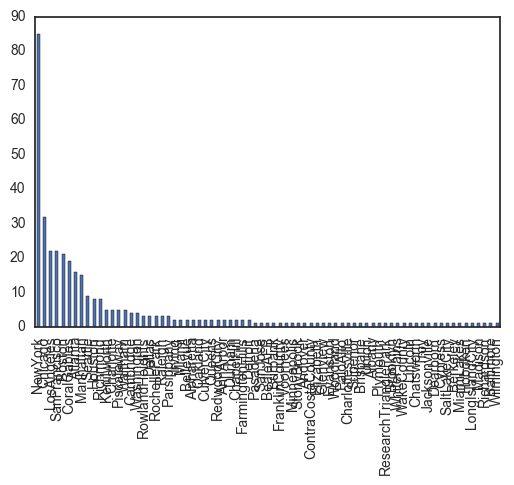

In [120]:
City_count.plot.bar()

In [121]:
pd.crosstab(df8['Sal_class'],df8['City'])
# There are 75 columns and most cities have very few data in the high and low salary class

City,Albany,Alpharetta,Andover,AnnArbor,Atlanta,Baltimore,BealeAFB,Bellevue,Berkeley,Boston,...,Superior,Troy,Union,Voorhees,WakeCounty,Waltham,Washington,WhitePlains,Wilmington,Woodland
Sal_class,,,,,,,,,,,,,,,,,,,,,
0,1,2,1,1,12,1,1,2,1,8,...,0,0,0,1,1,0,2,0,0,1
1,0,0,0,1,4,0,0,0,0,13,...,1,1,1,0,0,5,2,1,1,0


In [122]:
State_count = df8['State'].value_counts()
State_count

NY    107
CA     64
IL     34
MA     32
FL     23
NJ     20
GA     18
NC     14
TX     14
WA     11
VA      9
MI      9
DC      4
CO      1
KY      1
WI      1
UT      1
NE      1
MN      1
MD      1
Name: State, dtype: int64

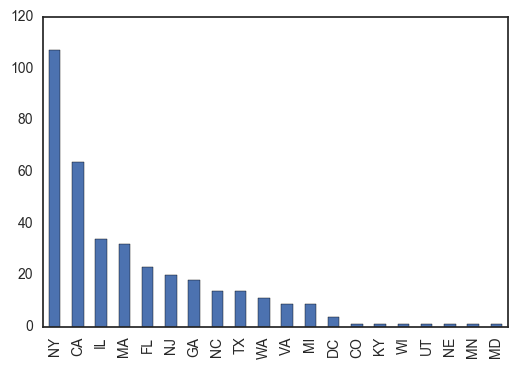

In [123]:
State_count.plot.bar()

Bar chart showing the number of jobs that were posted in each state that had the title 'Data Scientist'

In [124]:
# The same plot as above using groupby.
#State_group = df8['Sal_class'].groupby(df8['State'])
#State_group.count()
#State_group.count().plot.bar()

In [125]:
pd.crosstab(df8['Sal_class'],df8['State'])
# Data grouped by state has 20 columns

State,CA,CO,DC,FL,GA,IL,KY,MA,MD,MI,MN,NC,NE,NJ,NY,TX,UT,VA,WA,WI
Sal_class,,,,,,,,,,,,,,,,,,,,
0,27,0,2,21,14,14,1,9,1,5,1,6,1,14,41,10,1,9,5,0
1,37,1,2,2,4,20,0,23,0,4,0,8,0,6,66,4,0,0,6,1


In [126]:
df8.Sal_class = df8.Sal_class.astype(float)
df8['intercept']=1.0
df8

,Company_Name,Job_Title,City,State,Sal_min,Sal_max,Sal_avg,Sal_class,intercept
0,Centers for Disease Control and Prevention,Behavioral Scientist,Atlanta,GA,74260.0,96538.0,85399.0,0.0,1.0
1,Analytic Recruiting,Junior Data Scientist,Alpharetta,GA,75000.0,90000.0,82500.0,0.0,1.0
2,Smith Hanley Associates,Marketing Statistician,Atlanta,GA,75000.0,100000.0,87500.0,0.0,1.0
3,Analytic Recruiting,Senior Data Scientist,Atlanta,GA,100000.0,125000.0,112500.0,1.0,1.0
4,Stackfolio,Lead Data Scientist,Atlanta,GA,80000.0,NaN,80000.0,0.0,1.0
5,Analytic Recruiting,Data Scientist - Supply Chain,Atlanta,GA,70000.0,145000.0,107500.0,1.0,1.0
6,Emory University,Staff Scientist (Goldsmith Lab),Atlanta,GA,85500.0,NaN,85500.0,0.0,1.0
7,Centers for Disease Control and Prevention,Statistician (Health),Atlanta,GA,88305.0,114802.0,101553.5,1.0,1.0
8,CSTE,Associate Research Analyst,Atlanta,GA,51706.0,NaN,51706.0,0.0,1.0
9,SearchBankingJobs,Lead Quantitative Analyst,Atlanta,GA,150000.0,205000.0,177500.0,1.0,1.0


In [127]:
y, X=patsy.dmatrices('Sal_class ~ State', data=df8)
logit = sm.Logit(y,X)
result=logit.fit(method='ncg')
result.summary()

Optimization terminated successfully.
         Current function value: 0.600713
         Iterations: 13
         Function evaluations: 14
         Gradient evaluations: 26
         Hessian evaluations: 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Sal_class   No. Observations:                  366
Model:                          Logit   Df Residuals:                      346
Method:                           MLE   Df Model:                           19
Date:                Tue, 22 Nov 2016   Pseudo R-squ.:                  0.1333
Time:                        06:16:37   Log-Likelihood:                -219.86
converged:                       True   LL-Null:                       -253.69
                                        LLR p-value:                 2.250e-07
===============================================================================
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept       0.3151      0.253      1.245      0.213        -0.181     0.811
State[T.CO]    10.6343    238.582      0.045      0.964      -456.978   478.247
State[T.DC]    -0.3151      1.032     -0.305      0.760        -2.337     1.707
State[T.FL]    -2.6665      0.782     -3.409      0.001        -4.199    -1.134
State[T.GA]    -1.5678      0.621     -2.525      0.012        -2.785    -0.351
State[T.IL]     0.0416      0.431      0.097      0.923        -0.803     0.886
State[T.KY]   -11.2644    238.580     -0.047      0.962      -478.872   456.343
State[T.MA]     0.6232      0.468      1.333      0.183        -0.293     1.540
State[T.MD]   -11.2644    238.580     -0.047      0.962      -478.872   456.343
State[T.MI]    -0.5382      0.717     -0.751      0.453        -1.943     0.867
State[T.MN]   -11.2644    238.580     -0.047      0.962      -478.872   456.343
State[T.NC]    -0.0274      0.596     -0.046      0.963        -1.196     1.142
State[T.NE]   -11.2644    238.580     -0.047      0.962      -478.872   456.343
State[T.NJ]    -1.1624      0.550     -2.115      0.034        -2.240    -0.085
State[T.NY]     0.1610      0.322      0.500      0.617        -0.470     0.792
State[T.TX]    -1.2314      0.643     -1.914      0.056        -2.493     0.030
State[T.UT]   -11.2644    238.580     -0.047      0.962      -478.872   456.343
State[T.VA]   -13.4617    238.581     -0.056      0.955      -481.072   454.148
State[T.WA]    -0.1328      0.656     -0.202      0.840        -1.419     1.154
State[T.WI]    10.6343    238.582      0.045      0.964      -456.978   478.247
===============================================================================
"""

The base case(state) is California. The coefficients give the odds ratio of getting a high salary decreases 2.6665 times if the state is Florida. The p-value at alpha=0.05 is statistically signficant.

#### Create a few new variables in your dataframe to represent interesting features of a job title.
- For example, create a feature that represents whether 'Senior' or 'Manager' is in the title 
- Then build a new Logistic Regression model with these features. Do they add any value? 


In [128]:
# create senior, director, and manager dummies
df8['is_senior'] = df8['Job_Title'].str.contains('Senior').astype(int)
df8['is_manager'] = df8['Job_Title'].str.contains('Manager').astype(int)
df8['is_director'] = df8['Job_Title'].str.contains('Director').astype(int)
df8

#There are 43 senior, 17 manager and 10 director Job titles

,Company_Name,Job_Title,City,State,Sal_min,Sal_max,Sal_avg,Sal_class,intercept,is_senior,is_manager,is_director
0,Centers for Disease Control and Prevention,Behavioral Scientist,Atlanta,GA,74260.0,96538.0,85399.0,0.0,1.0,0,0,0
1,Analytic Recruiting,Junior Data Scientist,Alpharetta,GA,75000.0,90000.0,82500.0,0.0,1.0,0,0,0
2,Smith Hanley Associates,Marketing Statistician,Atlanta,GA,75000.0,100000.0,87500.0,0.0,1.0,0,0,0
3,Analytic Recruiting,Senior Data Scientist,Atlanta,GA,100000.0,125000.0,112500.0,1.0,1.0,1,0,0
4,Stackfolio,Lead Data Scientist,Atlanta,GA,80000.0,NaN,80000.0,0.0,1.0,0,0,0
5,Analytic Recruiting,Data Scientist - Supply Chain,Atlanta,GA,70000.0,145000.0,107500.0,1.0,1.0,0,0,0
6,Emory University,Staff Scientist (Goldsmith Lab),Atlanta,GA,85500.0,NaN,85500.0,0.0,1.0,0,0,0
7,Centers for Disease Control and Prevention,Statistician (Health),Atlanta,GA,88305.0,114802.0,101553.5,1.0,1.0,0,0,0
8,CSTE,Associate Research Analyst,Atlanta,GA,51706.0,NaN,51706.0,0.0,1.0,0,0,0
9,SearchBankingJobs,Lead Quantitative Analyst,Atlanta,GA,150000.0,205000.0,177500.0,1.0,1.0,0,0,0


#### Rebuild this model with scikit-learn.
- You can either create the dummy features manually or use the `dmatrix` function from `patsy`
- Remember to scale the feature variables as well!


In [129]:
Y,X=patsy.dmatrices('Sal_class~ State', data=df8)
logreg = LogisticRegression(random_state=77,C=5)
logreg.fit(X, Y)
Y_pred1 = logreg.predict(X)
ypro = logreg.predict_proba(X)
logreg.score(X,Y)

//anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.66120218579234968

#### Use cross-validation in scikit-learn to evaluate the model above. 
- Evaluate the accuracy, AUC, precision and recall of the model. 
- Discuss the differences and explain when you want a high-recall or a high-precision model in this scenario.

### Compare L1 and L2 regularization for this logistic regression model. What effect does this have on the coefficients learned?

In [130]:
#using l2 penalty

X=patsy.dmatrix('~ State', data=df8)
Y = df8['Sal_class']
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.33, random_state=77)
clf = LogisticRegressionCV(Cs=15,cv=5,solver = 'liblinear', penalty="l2")
clf.fit(X_train,Y_train)
Y_pred1 = clf.predict(X_train)
ypro = clf.predict_proba(X_train)
print clf.coef_

print cross_val_score(clf, X_train, Y_train)

[[-0.06720222  0.42726263 -0.37516603 -1.63076185 -0.50120977  0.58143562
  -0.37516603  0.74456385  0.         -0.32399299  0.         -0.14853662
  -0.37516603 -0.73284935  0.7059073  -0.59022346  0.         -1.32245831
   0.08055964  0.42726263]]
[ 0.57317073  0.59756098  0.65432099]


In [131]:
#using l1 penalty

X=patsy.dmatrix('~ State', data=df8)
Y = df8['Sal_class']
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.33, random_state=77)
clf = LogisticRegressionCV(Cs=15,cv=5,solver = 'liblinear', penalty="l1")
clf.fit(X_train,Y_train)
Y_pred1 = clf.predict(X_train)
ypro = clf.predict_proba(X_train)
print clf.coef_
print cross_val_score(clf, X_train, Y_train)

#for metric in ['accuracy', 'precision', 'recall', 'roc_auc']: # example
    

[[ 0.07385542  2.40707385 -2.70661649 -2.90923647 -0.93483166  0.39574377
  -2.70659844  0.59733957  0.         -0.78940153  0.         -0.49560951
  -2.70661448 -1.22452695  0.45905946 -1.09784847  0.         -4.71688187
  -0.10179008  2.40707385]]
[ 0.57317073  0.6097561   0.67901235]


In [132]:
#confusion matrix when cross validation is done using penalty l1.
Y_pred = clf.predict(X_test)

conmat = np.array(confusion_matrix(Y_test, Y_pred))

confusion = pd.DataFrame(conmat, index=['actual_low', 'actual_High'],columns=['predicted_low', 'predicted_high'])

print(confusion)

             predicted_low  predicted_high
actual_low              20              37
actual_High             14              50


In [133]:
acc = accuracy_score(Y_test, Y_pred)
print('Accuracy of the model:',acc)
cls_rep = classification_report(Y_test, Y_pred)
print(cls_rep)

('Accuracy of the model:', 0.57851239669421484)
             precision    recall  f1-score   support

        0.0       0.59      0.35      0.44        57
        1.0       0.57      0.78      0.66        64

avg / total       0.58      0.58      0.56       121



Accuracy is the total number of positive prediction for the entire dataset. Precision is the number of positive 
predictions that were actually positive. Recall is the number of positive predictions of all the positive outcomes.

In this senario of predicting salaries based on location- a high recall means either a high true positive or a very low false negative. This means reducing the number of predictions that are wrongly classified under high salary. If more number of salaried above 100K can be correctly predicted then there would be less problem of paying someone higher salary even if they dont deserve it.

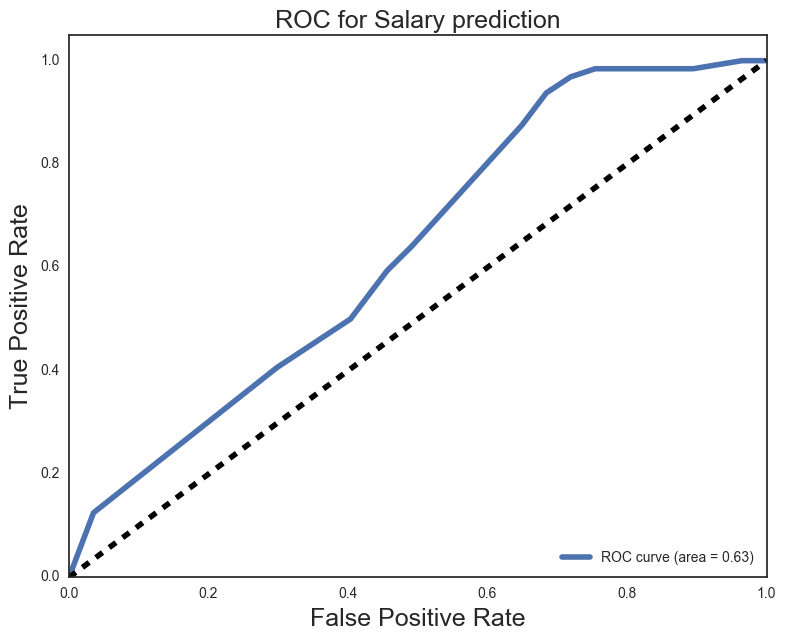

In [134]:
Y_score = logreg.decision_function(X_test)

FPR = dict()
TPR = dict()
ROC_AUC = dict()

# For class 1, find the area under the curve
FPR[1], TPR[1], _ = roc_curve(Y_test, Y_score)
ROC_AUC[1] = auc(FPR[1], TPR[1])

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[9,7])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC for Salary prediction', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [135]:
%%html
<div class='tableauPlaceholder' id='viz1479812883465' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;In&#47;Indeed_salary_viz&#47;Jobsbystate&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='site_root' value='' /><param name='name' value='Indeed_salary_viz&#47;Jobsbystate' /><param name='tabs' value='yes' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;In&#47;Indeed_salary_viz&#47;Jobsbystate&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1479812883465');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

1. The total number of job postings was 366 when searched on indeed.com with title that had 'Data Scientist' in them across 15 cities. NY and CA account for 50% of the job postings.
1. The minimum salary that was offered for a Data scientist positionin each state shows that MA leads the list with 108K followed very closely by CA. DUe to the high cost of living in these states(cities) the minimum salary is high.


Summary:
1. Job details of Data Scientist positons in 15 cities across the US were web scrapped to predict the salries based on 
location, job description and job titles.
1. The problem was evaluated as a classification problem in identifying a job (title, description) as belonging to high salary class(salary>$100k/year) based on location, description and job title.
1. The model- ogistic regression with cross validation had an accuracy and precision of 58%.
1. The model can be improved further if additional details were available or looked into more closely from the current data. Additional details can include text features within the summary of each job.

Blog link:
%%html
http://wp.me/p85kqG-1J

#### Optional: Continue to incorporate other text features from the title or summary that you believe will predict the salary and examine their coefficients. Take ~100 scraped entries with salaries. Convert them to use with your model and predict the salary. Which entries have the highest predicted salaries?

# Bonus Section: Use Count Vectorizer from scikit-learn to create features from the text summaries. 
- Examine using count or binary features in the model
- Re-evaluate the logistic regression model using these. Does this improve the model performance? 
- What text features are most valuable? 

In [137]:
# from sklearn.feature_extraction.text import CountVectorizer

# vectorizer = CountVectorizer()
# X = vectorizer.fit_transform()

# for metric in ['accuracy', 'precision', 'recall', 'roc_auc']:
#     scores = cross_val_score(model, X_scaled, y, cv=3, scoring=metric)
#     print(metric, scores.mean(), scores.std())

In [138]:
# model.fit(X_scaled, y)

# df = pd.DataFrame({'features' : vectorizer.get_feature_names(), 'coef': model.coef_[0,:]})
# df.sort_values('coef', ascending=False, inplace=True)

In [139]:
# df.head()

In [140]:
# df.tail()

In [141]:
# # retest L1 and L2 regularization
# from sklearn.linear_model import LogisticRegressionCV

# model = LogisticRegressionCV()


Score: | /24
------|-------
Identify: Problem Statement and Hypothesis | 
Acquire: Import Data using BeautifulSoup| 
Parse: Clean and Organize Data| 
Model: Perform Logistic Regression| 
Evaluate: Logistic Regression Results	|
Present: Blog Report with Findings and Recommendations		| 
Interactive Tableau visualizations | 
Regularization |
Bonus: Countvectorizer  | 